In [1]:
import os
import cv2
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
model = load_model('model-logs/effB0/effB0_224.h5')

In [3]:
def bbox_by_black(img):
    
    block=2
    center_distance_ratio=1/4
    
    top=0
    bot=0
    left=0
    right=0

    for y in range(int(img[:,:,0].shape[0]/2+img[:,:,0].shape[0]*center_distance_ratio),img[:,:,0].shape[0]-1):
        if img[y,:,0].mean()<block:
            top=y
            break
    if top==0:
        top=img[:,:,0].shape[0]


    for y in range(int(img[:,:,0].shape[0]/2-img[:,:,0].shape[0]*center_distance_ratio),0,-1):
        if img[y,:,0].mean()<block:
            bot=y
            break


    for x in range(int(img[bot:top,:,0].shape[1]/2+img[bot:top,:,0].shape[1]*center_distance_ratio),img[bot:top,:,0].shape[1]-1):
        if img[bot:top,x,0].mean()<block:
            right=x
            break

    if right==0:
        right=img[bot:top,:,0].shape[1]


    for x in range(int(img[bot:top,:,0].shape[1]/2-img[bot:top,:,0].shape[1]*center_distance_ratio),0,-1):
        if img[bot:top,x,0].mean()<block:
            left=x
            break
    
    return left,right,bot,top

In [4]:
def preprocess(file_path, img_size=224):
    img_bgr = cv2.imread(file_path)
    thresh = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    x1, x2, y1, y2 = bbox_by_black(thresh)
    crop_img = img_bgr[y1:y2, x1:x2].astype('float32')
    img = tf.image.resize_with_pad(crop_img, img_size, img_size)
    return img

In [5]:
classes = open('./classes.txt', 'r').read().split('\n')

In [6]:
org_data = sorted(glob.glob('./U-2-Net/test_data/test_images/' + os.sep + '*'))
mask_data = sorted(glob.glob('./U-2-Net/test_data/test_results/' + os.sep + '*'))

In [7]:
img = preprocess(mask_data[0], 224)

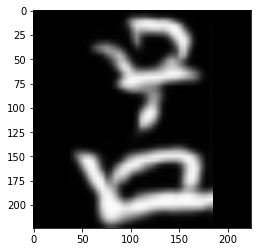

In [8]:
plt.imshow(img.numpy()/255)

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
# preds = []
# labels = []
# for file in data:
#     img = preprocess(file, 224)
#     inputs = np.expand_dims(img, axis=0)
#     pred = model.predict(inputs)
#     pred_class = classes[pred.argmax(-1)[0]]
#     pred_conf = pred[0][pred.argmax(-1)[0]]
#     if pred_conf <= 0.5:
#         pred_class = 'is_null'
#     preds.append(pred_class)
#     gt = file.split('.')[0][-1]
#     if gt not in classes:
#         gt = 'is_null'
#     labels.append(gt)

In [11]:
# accuracy_score(labels, preds)

In [14]:
cnt = 0
for org, mask in zip(org_data, mask_data):
    img = preprocess(mask, 224)
    inputs = np.expand_dims(img, axis=0)
    pred = model.predict(inputs)
    pred_class = classes[pred.argmax(-1)[0]]
    pred_conf = pred[0][pred.argmax(-1)[0]]
    if pred_conf <= 0.5:
        pred_class = 'isnull'
    cnt+=1
    shutil.copy(org, f'./output/{str(cnt).zfill(5)}_{pred_class}.jpg')